## Import all what we need.

In [147]:
import os
import math
import glob
import time
import pylab
import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
from numba import jit
from io import StringIO
import matplotlib.pyplot as plt

## The Input File Path


<table><tr><td bgcolor=skyblue><font size=24> Could be changed ! </font></td></tr></table>

In [148]:
inp_filepath = 'hitran.inp'

## Report time

In [149]:
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self

    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start

## Read Information from Input File

In [150]:
def inp_para(inp_filepath):
    
    inp_col_name = ['c0', 'c1', 'c2']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    database = inp_df[col0.isin(['Database'])]['c1'].values[0]
    molecule = inp_df[col0.isin(['Molecule'])]['c1'].values[0]
    isotopologue = inp_df[col0.isin(['Isotopologue'])]['c1'].values
    iso = int(inp_df[col0.isin(['iso'])]['c1'])
    T = int(inp_df[col0.isin(['Temperature'])]['c1'])
    min_wn = float(inp_df[col0.isin(['Range'])]['c1'])
    max_wn = float(inp_df[col0.isin(['Range'])]['c2'])
    N_point = int(inp_df[col0.isin(['Npoints'])]['c1'])
    profile = inp_df[col0.isin(['Profile'])]['c1'].values[0]
    wn_wl = inp_df[col0.isin(['Wavenumber(wn)/wavelength(wl)'])]['c1'].values[0]
    saveplots = inp_df[col0.isin(['SavePlots'])]['c1'].values[0]
    savexsecs = inp_df[col0.isin(['SaveXsecs'])]['c1'].values[0]

    molecule_id = int(iso/10)
    isotopologue_id = iso - molecule_id * 10
    isometa_url = 'https://hitran.org/docs/iso-meta/'
    iso_meta_table = pd.read_html(isometa_url)[molecule_id - 1]
    iso_meta_row = iso_meta_table[iso_meta_table['local ID'].isin([isotopologue_id])]
    abundance = float(iso_meta_row['Abundance'][0].replace('\xa0×\xa010','E'))
    mass = float(iso_meta_row['Molar Mass /g·mol-1'])
    Q_ref = float(iso_meta_row.loc[0][6].replace('\xa0×\xa010','E'))
    Q_url = 'https://hitran.org/data/Q/' + iso_meta_row.loc[0][7]
    Q_content = requests.get(Q_url).text
    Q_col_name = ['T', 'Q']
    Q_df = pd.read_csv(StringIO(Q_content), sep='\\s+', names=Q_col_name, header=None)
    Q = Q_df['Q'][T - 1]
    
    return database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q


## Constants and Parameters

In [151]:
# HITRAN Parameters for calculating.
import astropy.constants as ac
database, molecule, T, min_wn, max_wn, N_point, profile, wn_wl, saveplots, savexsecs, molecule_id, isotopologue_id, abundance, mass, Q_ref, Q = inp_para(inp_filepath)
T_ref = 296                     # Reference temperature is 296 K.
P_ref = 1                       # Reference pressure is 1 atm.
P = 1
N_A = ac.N_A.value              # Avogadro number (mol^{-1})
h = ac.h.to('J s').value        # Planck's const (J s)
c = ac.c.to('cm/s').value       # Velocity of light (cm s^{-1})
kB = ac.k_B.to('J/K').value     # Boltzmann's const (J K^{-1})
c2 = h * c / kB                 # Second radiation constant (cm K)
c2_T = c2 / T                   # c2 / T (cm)
c2_T_ref = c2 / T_ref           # c2 / T_ref (cm)

ratio_air = 0.7
ratio_self = 0.3
cutoff = 25.0


## Read HITRAN Format Input File

Read the parameters of the molecular absorption features of HITRAN2016 format text file. Return the dataframe of the HITRAN data for the following calculations.

In [152]:
def read_hitran2016_parfile (par_filepath):
    '''
    Read the parameters of the molecular absorption features
    of HITRAN2016 format text file.
    
    Parameters
    ----------
    par_filepath : str
        Input file path for reading.
    Return
    ------
    hitran_df : DataFrame
        The DataFrame of HITRAN data for the molecule.
    '''    
    par_filename = par_filepath.split('/')[3]
    
    if not os.path.exists:
        raise ImportError('The input file ' + par_filename + ' does not exist.')

    par_df = dict()
    parfile_df = pd.DataFrame()

    par_df[par_filepath] = pd.read_csv(par_filepath, header=None, chunksize=100_000_000, iterator=True, low_memory=False)
    for chunk in par_df[par_filepath]:
        parfile_df = parfile_df.append(chunk)

    if (len(str(parfile_df[0][0])) < 160):
        raise ImportError('The file ' + par_filename + ' is not a HITRAN2016 format data file.')
    #hitran_column_name = ['M','I','v','S','Acoeff','gamma_air','gamma_self',
    #                     'Epp','n_air','delta_air','Vp','Vpp','Qp','Qpp',
    #                     'Ierr','Iref','flag','gp','gpp']

    hitran_df = pd.DataFrame()

    hitran_df['M'] = pd.to_numeric(parfile_df[0].map(lambda x: x[0:2]), errors='coerce').astype('int64')                 # Molecule identification number
    hitran_df['I'] = pd.to_numeric(parfile_df[0].map(lambda x: x[2:3]), errors='coerce').astype('int64')                 # Isotopologue number
    hitran_df['v'] = pd.to_numeric(parfile_df[0].map(lambda x: x[3:15]), errors='coerce').astype('float64')              # Transition wavenumber (in cm^{-1})
    hitran_df['S'] = pd.to_numeric(parfile_df[0].map(lambda x: x[15:25]), errors='coerce').astype('float64')             # Intensity (cm^{-1} / (molecule cm^{-2})
    hitran_df['Acoeff'] = pd.to_numeric(parfile_df[0].map(lambda x: x[25:35]), errors='coerce').astype('float64')        # Einstein A-coefficient (in s^{-1})
    hitran_df['gamma_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[35:40]), errors='coerce').astype('float64')     # Air-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['gamma_self'] = pd.to_numeric(parfile_df[0].map(lambda x: x[40:45]), errors='coerce').astype('float64')    # Self-broadened half-width at half maximum (HWHM) coefficient (cm^{-1} atm^{-1})
    hitran_df['Epp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[45:55]), errors='coerce').astype('float64')           # Lower state energy (cm^{-1})
    hitran_df['n_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[55:59]), errors='coerce').astype('float64')         # Temperature-dependent exponent for gamma_air
    hitran_df['delta_air'] = pd.to_numeric(parfile_df[0].map(lambda x: x[59:67]), errors='coerce').astype('float64')     # Air pressure_include line shift (cm^{-1} atm^{-1})
    hitran_df['Vp'] = parfile_df[0].map(lambda x: x[67:82])                                                              # Upper-state "global" quanta
    hitran_df['Vpp'] = parfile_df[0].map(lambda x: x[82:97])                                                             # Lower-state "global" quanta
    hitran_df['Qp'] = parfile_df[0].map(lambda x: x[97:112])                                                             # Upper-state "local" quanta
    hitran_df['Qpp'] = parfile_df[0].map(lambda x: x[112:127])                                                           # Lower-state "local" quanta
    hitran_df['Ierr'] = parfile_df[0].map(lambda x: x[127:133])                                                          # Uncertainty indices
    hitran_df['Iref'] = parfile_df[0].map(lambda x: x[133:145])                                                          # Reference indices
    hitran_df['flag'] = parfile_df[0].map(lambda x: x[145:146])                                                          # Flag
    hitran_df['gp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[146:153]), errors='coerce').astype('float64')          # Statistical weight of the upper state
    hitran_df['gpp'] = pd.to_numeric(parfile_df[0].map(lambda x: x[153:160]), errors='coerce').astype('float64')         # Statistical weight of the lower state

    #hitran_df = hitran_df[hitran_df['I'].isin([1])]
    
    return hitran_df


## Line Profile

In [153]:
@jit
def Doppler_HWHM (v, mass, T):
    '''Return the Doppler half-width at half-maximum (HWHM) -- alpha.'''
    alpha = np.sqrt(2 * N_A * kB * T * np.log(2) / mass) * v / c
    return alpha

@jit
def Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self):
    '''Return the Lorentzian half-width at half-maximum (HWHM) -- gamma.'''
    gamma = (gamma_air * ratio_air + gamma_self * ratio_self) * ((T_ref / T)**n_air) * (P / P_ref)
    return gamma

@jit
def Gaussian_profile(dv, alpha):
    '''Return Gaussian line profile at dv with HWHM alpha.'''
    alpha = alpha * 2
    Gaussian_profile = np.sqrt(np.log(2) / np.pi) / alpha * np.exp(-np.log(2) * dv**2 / alpha**2)
    #Gaussian_profile = np.exp(-(dv / alpha)**2 / 2) / alpha / np.sqrt(2 * np.pi)
    return Gaussian_profile

@jit
def Lorentzian_profile(dv, gamma):
    '''Return Lorentzian line profile at dv with HWHM gamma.'''
    gamma = gamma * 2
    Lorentzian_profile = gamma / np.pi / (dv**2 + gamma**2)
    return Lorentzian_profile


In [154]:
from scipy.special import voigt_profile
@jit
def scipy_Voigt_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.

    '''
    return voigt_profile(dv, alpha, gamma)

In [155]:
from scipy.special import wofz
@jit
def scipy_wofz_Voigt_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.

    '''
    sigma = alpha / np.sqrt(2 * np.log(2))
    scipy_wofz_Voigt_profile = np.real(wofz((dv + 1j*gamma)/sigma/np.sqrt(2))) / sigma / np.sqrt(2*np.pi)
    return scipy_wofz_Voigt_profile

In [156]:
@jit
def width_Voigt_profile(dv, f_G, f_L):
    '''
    Return the full width at half maximum (FWHM) of the Voigt profile which can
    be found from the widths of the associated Gaussian and Lorentzian widths.

    '''
    width_Voigt_profile = 0.5346 * f_L + np.sqrt(0.2166 * f_L**2 + f_G**2)
    return width_Voigt_profile

In [157]:
@jit
def pseudo_Voigt_profile(dv, f_G, f_L):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    
    '''
    pseudo_Voigt_profile = (f_G**5+2.69269*f_G**4*f_L+2.42843*f_G**3*f_L**2+4.47163*f_G**2*f_L**3+0.07842*f_G*f_L**4+f_L**5)**0.2
    
    return pseudo_Voigt_profile

In [158]:
@jit
def pseudo_Voigt_FWHM_profile(dv, alpha, gamma):
    '''
    Return the Voigt line profile with Lorentzian component HWHM gamma and Gaussian component HWHM alpha.
    f is the total FWHM parameter.
    n is a function of Lorentz (f_L), Gaussian (f_G) and total (f) full width at half maximum (FWHM) parameters.
    
    '''
    f_G = 2 * alpha * np.sqrt(2 * np.log(2))
    f_L = 2 * gamma
    f = (f_G**5 + 2.69269*f_G**4*f_L + 2.42843*f_G**3*f_L**2 + 4.47163*f_G**2*f_L**3 + 0.07842*f_G*f_L**4 + f_L**5)**0.2
    n = 1.36603*(f_L/f) - 0.47719*(f_L/f)**2 + 0.11116*(f_L/f)**3
    pseudo_fwhm_Voigt_profile = n*Lorentzian_profile(dv,f/2) + (1-n)*Gaussian_profile(dv,f/2)

    return pseudo_fwhm_Voigt_profile

## Calculate Cross Sections

In [159]:
@jit
def hitran_cross_section(hitran_df):
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with line profiles.
    
    '''
    
    hitran_df = hitran_df[hitran_df['v'] > min_wn]
    hitran_df = hitran_df[hitran_df['v'] < max_wn]
    nlines = len(hitran_df)
    wn_grid = np.linspace(min_wn - cutoff, max_wn + cutoff, N_point)
    S = hitran_df['S']
    Epp = hitran_df['Epp']
    n_air = hitran_df['n_air']
    gamma_air = hitran_df['gamma_air']
    gamma_self = hitran_df['gamma_self']
    v = hitran_df['v'] + hitran_df['delta_air'] * (P - P_ref) / P
    #v = hitran_df['v']
    
    alpha = Doppler_HWHM (v, mass, T)
    gamma = Lorentzian_HWHM (T, P, n_air, gamma_air, gamma_self)
    abscoef = S * Q_ref / Q * np.exp(c2 * Epp * (1/T_ref - 1/T)) * (1 - np.exp(-c2_T * v)) / (1 - np.exp(-c2_T_ref * v))
    
    return (nlines, wn_grid, v, alpha, gamma, abscoef)

In [160]:
@jit
def hitran_cross_section_Gaussian():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Gaussian profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_g = np.zeros_like(wn_grid)
    
    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        abscoef = abscoefs.values[i]

        dv = wn_grid - v
        xsec_g += abscoef * Gaussian_profile(dv, alpha)
        
    return (wn_grid, xsec_g)

In [161]:
@jit
def hitran_cross_section_Lorentzian():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Lorentzian profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_l = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_l += abscoef * Lorentzian_profile(dv, gamma)

    return (wn_grid, xsec_l)

In [162]:
@jit
def hitran_cross_section_scipy_Voigt():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with scipy Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_sv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_sv += abscoef * scipy_Voigt_profile(dv, alpha, gamma)

    return (wn_grid, xsec_sv)

In [163]:
@jit
def hitran_cross_section_scipy_wofz_Voigt():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_swv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_swv += abscoef * scipy_wofz_Voigt_profile(dv, alpha, gamma)

    return (wn_grid, xsec_swv)

In [164]:
@jit
def hitran_cross_section_width_Voigt():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with width Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_wv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        f_G = Gaussian_profile(dv, alpha)
        f_L = Lorentzian_profile(dv, gamma)
        xsec_wv += abscoef * width_Voigt_profile(dv, f_G, f_L)
        
    return (wn_grid, xsec_wv)

In [165]:
@jit
def hitran_cross_section_pseudo_Voigt():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with pseudo Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_pv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        f_G = Gaussian_profile(dv, alpha)
        f_L = Lorentzian_profile(dv, gamma)        
        xsec_pv += abscoef * pseudo_Voigt_profile(dv, f_G, f_L)
        
    return (wn_grid, xsec_pv)

In [166]:
@jit
def hitran_cross_section_pseudo_FWHM_Voigt():
    '''
    Read HITRAN .par file as the input file.
    Return the wavennumbers and cross sections with pseudo Voigt profile.
    
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    xsec_pfv = np.zeros_like(wn_grid)

    for i in tqdm(range(nlines)):
        
        v = vs.values[i]
        alpha = alphas.values[i]
        gamma = gammas.values[i]
        abscoef = abscoefs.values[i]
        
        dv = wn_grid - v
        xsec_pfv += abscoef * pseudo_Voigt_FWHM_profile(dv, alpha, gamma)
        
    return (wn_grid, xsec_pfv)

## Plot and Save Results

In [167]:
def plot_hitran_xsec_Gaussian():
    if wn_wl == 'wn':
        start = time.clock()
        (wn, xsec_g) = hitran_cross_section_Gaussian()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')

        xsec_g_df = pd.DataFrame()
        xsec_g_df['wavenumber'] = wn
        xsec_g_df['cross-section'] = xsec_g
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Gaussian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_g)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_g, label='T = 500 K, Gaussian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Gaussian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_Gaussian()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavelength'] = wl
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Gaussian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_l, label='T = 500 K, Gaussian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Gaussian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    else:
        print('Please type in correct format: wn or wl.')
        


In [168]:
def plot_hitran_xsec_Lorentzian():
    if (wn_wl == 'wn'):
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_Lorentzian()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
        
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavenumber'] = wn
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_l)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_Lorentzian()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_l_df = pd.DataFrame()
        xsec_l_df['wavelength'] = wl
        xsec_l_df['cross-section'] = xsec_l
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_l)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_l, label='T = 500 K, Lorentzian profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__Lorentzian__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    else:
        print('Please type in correct format: wn or wl.')

In [169]:
def plot_hitran_xsec_scipy_Voigt():
    if wn_wl =='wn':      
        start = time.clock()
        (wn, xsec_sv) = hitran_cross_section_scipy_Voigt()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
        
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavenumber'] = wn
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_sv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_scipy_Voigt()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_sv_df = pd.DataFrame()
        xsec_sv_df['wavelength'] = wl
        xsec_sv_df['cross-section'] = xsec_sv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_sv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_sv, label='T = 500 K, scipy Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [170]:
def plot_hitran_xsec_scipy_wofz_Voigt():
    if wn_wl == 'wn':
        start = time.clock()
        (wn, xsec_swv) = hitran_cross_section_scipy_wofz_Voigt()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
        
        xsec_swv_df = pd.DataFrame()
        xsec_swv_df['wavenumber'] = wn
        xsec_swv_df['cross-section'] = xsec_swv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyWofzVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_swv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_swv, label='T = 500 K, scipy wofz Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__ScipyWofzVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_scipy_wofz_Voigt()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_swv_df = pd.DataFrame()
        xsec_swv_df['wavelength'] = wl
        xsec_swv_df['cross-section'] = xsec_swv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyWofzVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_swv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_swv, label='T = 500 K, scipy wofz Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__ScipyWofzVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [171]:
def plot_hitran_xsec_width_Voigt():
    if wn_wl == 'wn':
        start = time.clock()
        (wn, xsec_wv) = hitran_cross_section_width_Voigt()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
            
        xsec_wv_df = pd.DataFrame()
        xsec_wv_df['wavenumber'] = wn
        xsec_wv_df['cross-section'] = xsec_wv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__WidthVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_wv)).T)
        print('Saved xsec file.')
            
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_wv, label='T = 500 K, width Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__WidthVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_width_Voigt()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_wv_df = pd.DataFrame()
        xsec_wv_df['wavelength'] = wl
        xsec_wv_df['cross-section'] = xsec_wv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__WidthVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_wv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_wv, label='T = 500 K, width Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__WidthVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [172]:
def plot_hitran_xsec_pseudo_Voigt():
    if wn_wl == 'wn':
        start = time.clock()
        (wn, xsec_pv) = hitran_cross_section_pseudo_Voigt()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')    
        
        xsec_pv_df = pd.DataFrame()
        xsec_pv_df['wavenumber'] = wn
        xsec_pv_df['cross-section'] = xsec_pv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_pv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_pv, label='T = 500 K, pseudo Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__PseudoVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_pseudo_Voigt()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_pv_df = pd.DataFrame()
        xsec_pv_df['wavelength'] = wl
        xsec_pv_df['cross-section'] = xsec_pv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_pv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_pv, label='T = 500 K, pseudo Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

In [173]:
def plot_hitran_xsec_pseudo_FWHM_Voigt():
    if wn_wl =='wn':
        start = time.clock()
        (wn, xsec_pfv) = hitran_cross_section_pseudo_FWHM_Voigt()
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavenumber range selected: ', min_wn, 'cm-1 - ', max_wn, 'cm-1')
            
        xsec_pfv_df = pd.DataFrame()
        xsec_pfv_df['wavenumber'] = wn
        xsec_pfv_df['cross-section'] = xsec_pfv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'cm-1-'+str(max_wn)+'cm-1__PseudoFWHMVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wn,xsec_pfv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wn, xsec_pfv, label='T = 500 K, pseudo FWHM Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavenumber, cm$^{-1}$')
        plt.ylabel('Cross-section, cm$^{2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wn)+'-'+str(max_wn)+'__PseudoFWHMVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')

    elif wn_wl == 'wl':
        start = time.clock()
        (wn, xsec_l) = hitran_cross_section_pseudo_FWHM_Voigt()
        wl = 10**7 / wn
        min_wl = 10**7 / min_wn
        max_wl = 10**7 / max_wn
        end = time.clock()
        t = end - start
        print('Running time :', t, 's')
        print('Temperature selected: ', T, 'K')
        print('Pressure selected: ', P, 'bar')
        print('Air broading is: ', ratio_air)
        print('Self broading is: ', ratio_self)
        print('Wavelength range selected: ', min_wl, 'nm - ', max_wl, 'nm')
        
        xsec_pfv_df = pd.DataFrame()
        xsec_pfv_df['wavelength'] = wl
        xsec_pfv_df['cross-section'] = xsec_pfv
        xsecs_foldername = savexsecs+molecule+'/'
        if os.path.exists(xsecs_foldername):
            pass
        else:
            os.makedirs(xsecs_foldername, exist_ok=True)
        xsec_filename = xsecs_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoFWHMVoigt__HITRAN.xsec'
        np.savetxt(xsec_filename, np.vstack((wl,xsec_pfv)).T)
        print('Saved xsec file.')
        
        fig = plt.figure(figsize=(12, 6))
        plt.plot(wl, xsec_pfv, label='T = 500 K, pseudo FWHM Voigt profile')
        plt.title('Molecule '+molecule)
        plt.xlabel('Wavelength, nm')
        plt.ylabel('Cross-section, nm$^{-2}$/molecule')
        plt.legend()
        plots_foldername = saveplots+molecule+'/'
        if os.path.exists(plots_foldername):
            pass
        else:
            os.makedirs(plots_foldername, exist_ok=True)    
        plt.savefig(plots_foldername+molecule+'__T'+str(T)+'__'+str(min_wl)+'nm-'+str(max_wl)+'nm__PseudoFWHMVoigt__HITRAN.png', dpi=500)
        plt.show()
        print('Saved xsec plots.')
        
    else:
        print('Please type in correct format: wn or wl.')

## Get Results

<ipython-input-161-ffd2eac93e84>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_Lorentzian" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-161-ffd2eac93e84>", line 8:
def hitran_cross_section_Lorentzian():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-161-ffd2eac93e84>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_Lorentzian" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-161-ffd2eac93e84>", line 8:
def hitran_cross_section_Lorentzian():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cr

Running time : 14.738904000000048 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


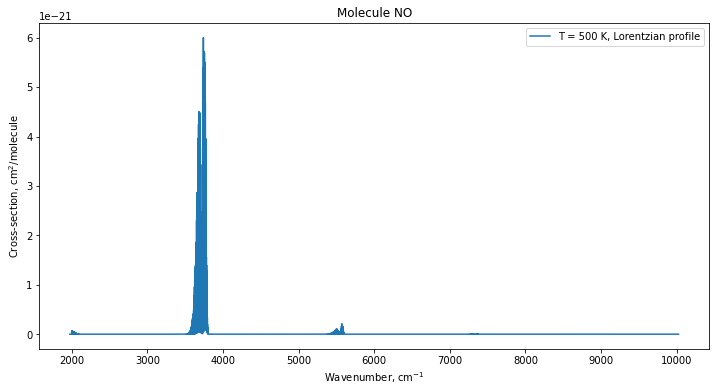

Saved xsec plots.


In [174]:
if database == 'HITRAN':
    inp_col_name = ['c0', 'c1', 'c2']
    inp_df = pd.read_csv(inp_filepath, sep='\\s+', names=inp_col_name, header=None)
    col0 = inp_df['c0']
    par_filepath = inp_df[col0.isin(['Transitions'])]['c1'].values[0]
    hitran_df = read_hitran2016_parfile(par_filepath)
if profile == 'Gaussian':
    plot_hitran_xsec_Gaussian()
elif profile == 'Lorentzian':
    plot_hitran_xsec_Lorentzian()
elif profile == 'scipy_Voigt':
    plot_hitran_xsec_scipy_Voigt()
elif profile == 'scipy_wofz_Voigt':
    plot_hitran_xsec_scipy_wofz_Voigt()
elif profile == 'width_Voigt':
    plot_hitran_xsec_width_Voigt()
elif profile == 'pseudo_Voigt':
    plot_hitran_xsec_pseudo_Voigt()
elif profile == 'pseudo_FWHM_Voigt':
    plot_hitran_xsec_pseudo_FWHM_Voigt()
else:
    print('Please choose line profile from the list.')

### Test

<ipython-input-160-e9a0d7ae4b76>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_Gaussian" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-160-e9a0d7ae4b76>", line 8:
def hitran_cross_section_Gaussian():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-160-e9a0d7ae4b76>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_Gaussian" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-160-e9a0d7ae4b76>", line 8:
def hitran_cross_section_Gaussian():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_sect

Running time : 208.84665099999995 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


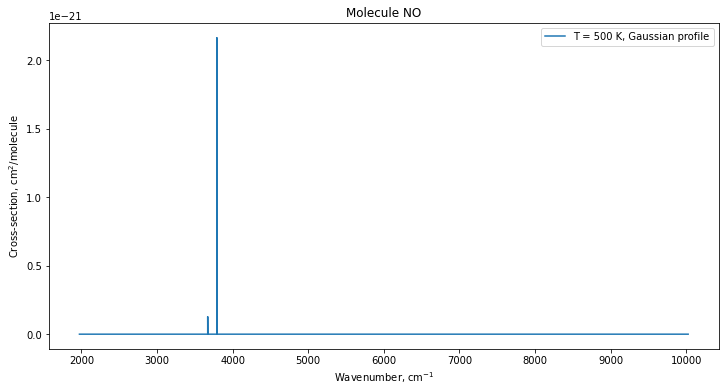

Saved xsec plots.


In [175]:
plot_hitran_xsec_Gaussian()

100%|██████████| 129890/129890 [00:14<00:00, 9006.49it/s]


Running time : 14.44789400000002 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


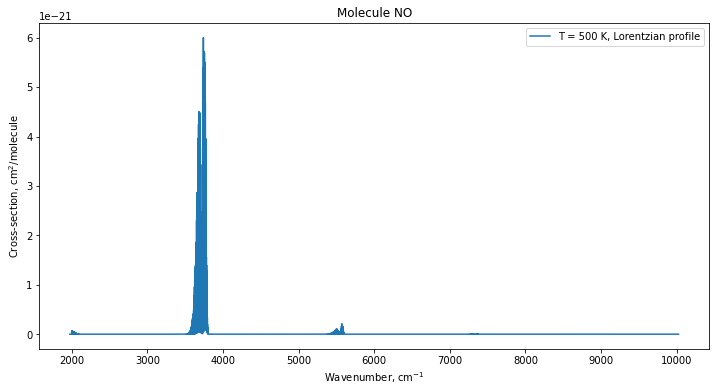

Saved xsec plots.


In [176]:
plot_hitran_xsec_Lorentzian()

<ipython-input-162-9d7cf87c6bcf>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_scipy_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-162-9d7cf87c6bcf>", line 8:
def hitran_cross_section_scipy_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-162-9d7cf87c6bcf>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_scipy_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-162-9d7cf87c6bcf>", line 8:
def hitran_cross_section_scipy_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitra

Running time : 150.77792200000005 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


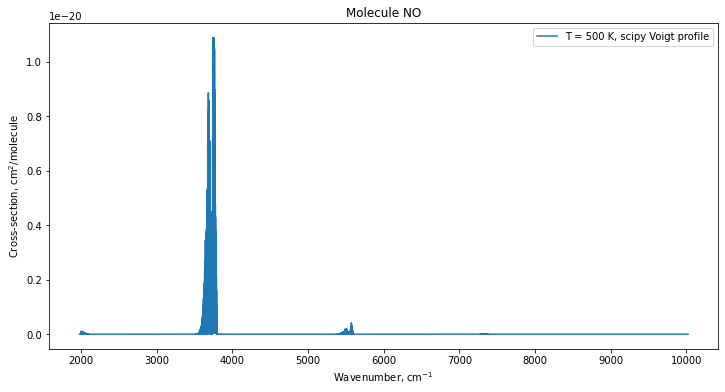

Saved xsec plots.


In [177]:
plot_hitran_xsec_scipy_Voigt()

<ipython-input-163-8dde2d23cd2c>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_scipy_wofz_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-163-8dde2d23cd2c>", line 8:
def hitran_cross_section_scipy_wofz_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-163-8dde2d23cd2c>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_scipy_wofz_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-163-8dde2d23cd2c>", line 8:
def hitran_cross_section_scipy_wofz_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gamm

Running time : 219.98828000000003 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


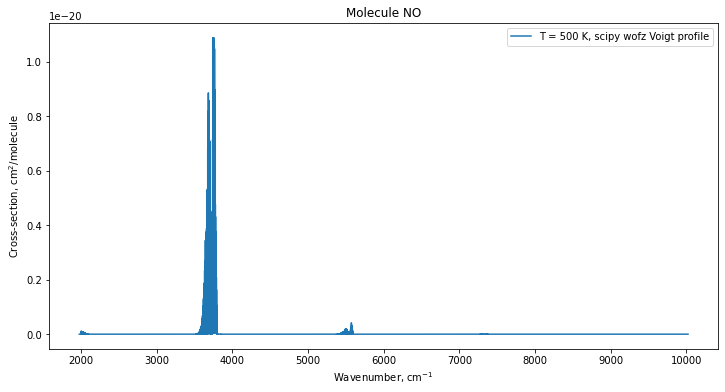

Saved xsec plots.


In [178]:
plot_hitran_xsec_scipy_wofz_Voigt()

<ipython-input-164-46f60fb762d0>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_width_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-164-46f60fb762d0>", line 8:
def hitran_cross_section_width_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-164-46f60fb762d0>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_width_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-164-46f60fb762d0>", line 8:
def hitran_cross_section_width_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitra

Running time : 221.37024999999994 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


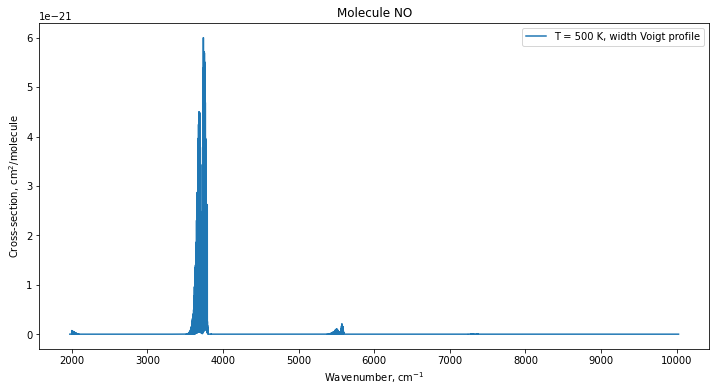

Saved xsec plots.


In [179]:
plot_hitran_xsec_width_Voigt()

<ipython-input-165-2dd2d98d82d2>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_pseudo_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-165-2dd2d98d82d2>", line 8:
def hitran_cross_section_pseudo_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-165-2dd2d98d82d2>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_pseudo_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-165-2dd2d98d82d2>", line 8:
def hitran_cross_section_pseudo_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = h

Running time : 614.669378 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


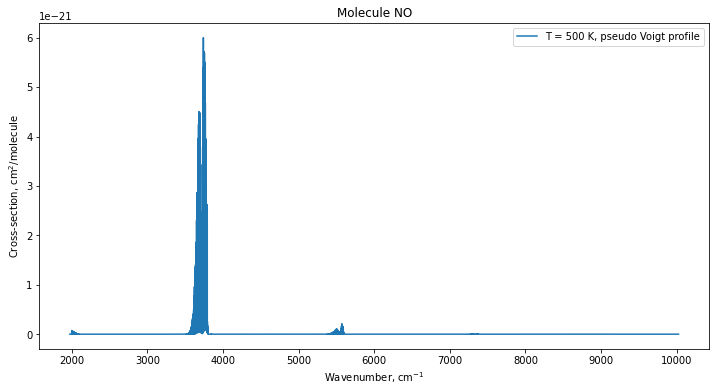

Saved xsec plots.


In [180]:
plot_hitran_xsec_pseudo_Voigt()

<ipython-input-166-86947c8180d4>:1: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "hitran_cross_section_pseudo_FWHM_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-166-86947c8180d4>", line 8:
def hitran_cross_section_pseudo_FWHM_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, gammas, abscoefs = hitran_cross_section(hitran_df)
    ^

  @jit
<ipython-input-166-86947c8180d4>:1: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "hitran_cross_section_pseudo_FWHM_Voigt" failed type inference due to: Untyped global name 'hitran_df': Cannot determine Numba type of <class 'pandas.core.frame.DataFrame'>

File "<ipython-input-166-86947c8180d4>", line 8:
def hitran_cross_section_pseudo_FWHM_Voigt():
    <source elided>
    '''
    nlines, wn_grid, vs, alphas, 

Running time : 217.66948899999988 s
Temperature selected:  500 K
Pressure selected:  1 bar
Air broading is:  0.7
Self broading is:  0.3
Wavenumber range selected:  2000.0 cm-1 -  10000.0 cm-1
Saved xsec file.


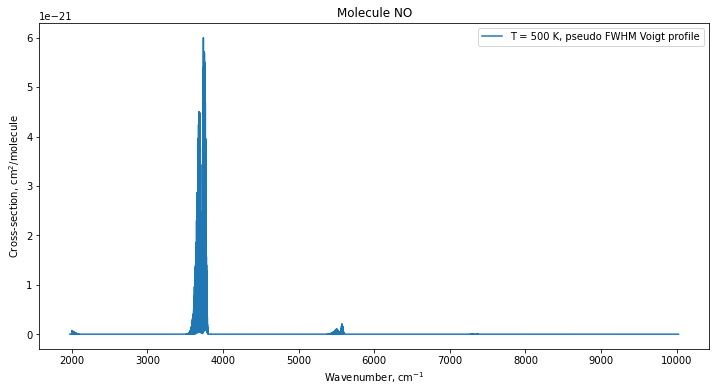

Saved xsec plots.


In [181]:
plot_hitran_xsec_pseudo_FWHM_Voigt()